# Scattering transform

Comparing the importance of different scales in a CNN with the importance with the Scattering Transform. Used on BDAPPV for now.
* implement a scattering transform

In [1]:
# Libraries

import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import torch
import torchvision
import torch.nn as nn
from kymatio.torch import Scattering2D
from kymatio.numpy import Scattering2D as npScattering2D
import tqdm
from src.bdappv import BDAPPVClassification
from src.utils import confusion
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

In [2]:
def get_K(L,J,num_channels=3):
    """
    L:number of angles of the scattering transform
    J: number of scales
    num_channels: number of input channels
    """
    return int(1 + L*J + (L**2)*J*((J-1)/2))*num_channels    

class Scattering2dCNN(nn.Module):
    '''
        Simple CNN with 3x3 convs based on VGG
    '''
    def __init__(self, J, \
                 input_shape,\
                 classifier_type='linear',\
                 L=8, \
                 num_classes=2):
        
        super(Scattering2dCNN, self).__init__()
        self.in_channels = get_K(L,J)
        self.J=J
        self.input_shape=input_shape
        self.classifier_type = classifier_type
        self.num_classes=num_classes
        self.build()

    def build(self):
        cfg = [256, 256, 256, 'M', 512, 512, 512, 1024, 1024]
        layers = []
        self.K = self.in_channels
        self.out_shape=self.input_shape // 2**self.J

        self.bn = nn.BatchNorm2d(self.K)
        if self.classifier_type == 'cnn':
            for v in cfg:
                if v == 'M':
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                else:
                    conv2d = nn.Conv2d(self.in_channels, v, kernel_size=3, padding=1)
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                    self.in_channels = v

            layers += [nn.AdaptiveAvgPool2d(2)]
            self.features = nn.Sequential(*layers)
            self.classifier =  nn.Linear(1024*4, self.num_classes)

        elif self.classifier_type == 'mlp':
            self.classifier = nn.Sequential(
                        nn.Linear(self.K*self.out_shape*self.out_shape, 1024), nn.ReLU(),
                        nn.Linear(1024, 1024), nn.ReLU(),
                        nn.Linear(1024, 10))
            self.features = None

        elif self.classifier_type == 'linear':
            self.classifier = nn.Linear(self.K*self.out_shape*self.out_shape,self.num_classes)
            self.features = None


    def forward(self, x):
        x = self.bn(x.view(-1, self.K, self.out_shape, self.out_shape))
        if self.features:
            x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [3]:
images_list = json.load(open("data/images_lists.json"))

dataset_dir = "../../data/bdappv"
models_dir="scattering"
batch_size = 512
device="cuda:1"

# baseline transforms: no corruptions
BASELINE = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor()#,
    #torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

datasets = {
    'google_test' : BDAPPVClassification(os.path.join(dataset_dir, "google"), size = 200, \
                                                    transform=BASELINE, images_list=images_list["test"], \
                                                        random = False, downsample=200),
    'ign_test'    : BDAPPVClassification(os.path.join(dataset_dir, "ign"), size = 200, \
                                                    transform=BASELINE, images_list=images_list["test"], \
                                                        random = False),
} 


## Quantitative evaluation 

We evaluate the trained models on Google and IGN

### Baseline model evaluation

In [4]:
def eval(model, device, test_loader, scattering):

    model.eval()
    tp, tn, fp, fn = 0, 0, 0, 0

    with torch.no_grad():
        for data, target, _ in tqdm.tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(scattering(data))
            preds=nn.functional.softmax(output, dim=1)
            preds=preds[:,1] # take the value predicted for the 2nd column
            pred = output.max(1, keepdim=True)[1].squeeze(1) # get the index of the max log-probability

            true_positives, false_positives, \
                true_negatives, false_negatives, _ = confusion(pred, target)
                        
            tp += true_positives
            tn += true_negatives
            fp += false_positives
            fn += false_negatives

    precision= tp / (tp+fp)
    recall=tp / (tp+fn)
    
    f1_score=2 * (precision * recall) / (precision + recall)
   
    return tp, tn, fp, fn, f1_score

In [14]:
eval_res={ # each count corresponds to a scale (J=1,2,3)
    1:{},
    2:{},
    3:{}
}
input_shape=200

for case in os.listdir(models_dir):

    if 'ign' in case:
        J=int(case.split('_')[2])
        scattering=Scattering2D(J=J, shape=(input_shape,input_shape)).to(device)

        tmp_dir=os.path.join(models_dir,case)

        model=torch.load(os.path.join(tmp_dir,"model_0.pth")) # load the best model
        model.eval()
        model.to(device)

        for case, key in zip(['Google', 'IGN'], datasets.keys()):

            eval_res[J][case]={}

            print('Evaluating case ...... {}'.format(case))
            dataset=torch.utils.data.DataLoader(datasets[key], batch_size=batch_size)

            tp, tn, fp, fn, f1_score=eval(model,device,dataset,scattering)

            eval_res[J][case]['confusion_matrix']=(tp,fp,tn,fn)
            eval_res[J][case]['f1_score']=f1_score

Evaluating case ...... Google


100%|██████████| 9/9 [00:44<00:00,  4.90s/it]


Evaluating case ...... IGN


100%|██████████| 9/9 [00:53<00:00,  5.99s/it]


Evaluating case ...... Google


100%|██████████| 9/9 [00:36<00:00,  4.07s/it]


Evaluating case ...... IGN


100%|██████████| 9/9 [00:51<00:00,  5.69s/it]


Evaluating case ...... Google


100%|██████████| 9/9 [00:27<00:00,  3.07s/it]


Evaluating case ...... IGN


100%|██████████| 9/9 [03:22<00:00, 22.52s/it]


In [15]:
overhead="&&F1 Score & TP & TN & FP & FN"
print(overhead)

for J in eval_res.keys():
    for case in eval_res[J].keys():
        
        f1=eval_res[J][case]['f1_score']
        tp, fp, tn, fn=eval_res[J][case]['confusion_matrix']

        var='&{}&{:0.2f}&{}&{}&{}&{}'.format(
            case, f1,tp,tn,fp,fn
        )
        print(var)

&&F1 Score & TP & TN & FP & FN
&Google&0.61&1866&42&2349&64
&IGN&0.61&1894&5&2415&7
&Google&0.62&1929&2&2389&1
&IGN&0.61&1901&0&2420&0
&Google&0.60&1480&864&1527&450
&IGN&0.55&1370&722&1698&531


In [63]:
def random_classifier_performance(positives, total):
    """
    returns the performance of a random classifier as a baseline
    """
    negatives=total-positives

    pos = positives/total
    neg = negatives/total
    # compute the confusion matrix for a model that randomly
    # predicts the class

    tp = total * pos * .5
    tn = total * neg * .5
    fp = total * neg * .5
    fn = total * pos * .5

    print(tp, tn, fp, fn)

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)

    f1=2*(precision*recall)/(precision+recall)
    return precision, recall, f1

J=1
for case in eval_res[J].keys():
    tp, fp, tn, fn=eval_res[J][case]['confusion_matrix']
    positives=tp+fn
    total=tp+tn+fp+fn


    precision, recall, f1=random_classifier_performance(positives,total)

    line = '{} : Precision: {:0.2f}, Recall: {:0.2f}, F1 : {:0.2f} '.format(case,
                                                                            precision,
                                                                            recall,
                                                                            f1)
    print(line)

965.0 1195.5 1195.5 965.0
Google : Precision: 0.45, Recall: 0.50, F1 : 0.47 
950.5 1210.0 1210.0 950.5
IGN : Precision: 0.44, Recall: 0.50, F1 : 0.47 


### Linear regressions

Consider different cases: 

A Linear regression on the image coefficients

A Lasso-regularized linear regression

In [4]:
def vectorize_images(dataset_dir, case, image_names, transform, num_samples=None):
    """
    returns a stacked vector of images
    """
    # google or ign directory
    images_dir=os.path.join(dataset_dir,case)

    positives=os.listdir(os.path.join(images_dir,'mask'))
    train_positives=[im for im in image_names if im in positives]
    train_negatives=[im for im in image_names if not im in positives]


    # get the positive and negative images


    if num_samples is None:
        pos_img=[
            transform(Image.open(os.path.join(images_dir + "/img", im)).convert('RGB')) for im in train_positives
        ]

        neg_img=[
            transform(Image.open(os.path.join(images_dir + "/img", im)).convert('RGB')) for im in train_negatives
        ]
    else:
        pos_img=[
            transform(Image.open(os.path.join(images_dir + "/img", im)).convert('RGB')) for im in train_positives[:num_samples]
        ]

        neg_img=[
            transform(Image.open(os.path.join(images_dir + "/img", im)).convert('RGB')) for im in train_negatives[:num_samples]
        ]

    print('Images loaded')

    # vectorize and stack the images
    size=pos_img[0].size[0] # get the size of the images

    X_pos=np.empty((len(pos_img), size**2*3 + 1))
    X_neg=np.empty((len(neg_img), size**2*3 + 1))

    # fill the arrays
    for i in range(X_pos.shape[0]):
        X_pos[i,:-1]=np.array(pos_img[i]).flatten()/255
        X_pos[i,-1]=1.

    for i in range(X_neg.shape[0]):
        X_neg[i,:-1]=np.array(neg_img[i]).flatten()/255
        X_neg[i,-1]=0.

    # stack into a single array
    X_final=np.concatenate((X_pos, X_neg), axis=0)
    np.random.seed(42)
    X_final=np.random.permutation(X_final)

    X=X_final[:,:-1]
    y=X_final[:,-1]

    return X, y

In [9]:
# set up the transforms and the paths

images_list = json.load(open("data/images_lists.json"))
dataset_dir = "../../data/bdappv"

RESIZE=torchvision.transforms.Compose([
    torchvision.transforms.Resize(200),
])

CROP=torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(200)
])

# case Google train 
case="google"
image_names=images_list['train']
X_train, y_train=vectorize_images(dataset_dir, case, image_names, RESIZE, num_samples=5000)
print(X_train.shape, y_train.shape)

# case Google test 
case="google"
image_names=images_list['test']
X_test, y_test=vectorize_images(dataset_dir, case, image_names, RESIZE)
print(X_test.shape, y_test.shape)

# case IGN test 
case="ign"
image_names=images_list['test']
X_ign, y_ign=vectorize_images(dataset_dir, case, image_names, CROP)
print(X_ign.shape, y_ign.shape)

Images loaded
(10000, 120000) (10000,)
Images loaded
(4321, 120000) (4321,)
Images loaded
(4321, 120000) (4321,)


In [10]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

print('Model fitted.')

y_pred=model.predict(X_test)
y_pred=(y_pred>0.5).astype(int)


y_ood=model.predict(X_ign)
y_ood=(y_ood>0.5).astype(int)

Model fitted.


In [12]:
# computatio nof the F1 score on Google and IGN
for pred, ref in zip([y_pred, y_ood], [y_test, y_ign]):
    true_positives, false_positives, \
    true_negatives, false_negatives, _ = confusion(pred, ref)

    precision=true_positives/(true_positives+true_negatives)
    recall=true_positives/(true_positives+false_negatives)

    f1=(2 * (precision*recall))/(precision+recall) 

    row='{:0.2f} & {} & {} & {} & {}'.format(
        f1, true_positives, true_positives, false_positives, false_negatives
    )

    print(row)

0.51 & 1356 & 1356 & 371 & 584
0.34 & 801 & 801 & 414 & 1130


/data/GabrielKasmi/deeppvmapper/wcam-application/src/utils.py:421: RuntimeWarning: divide by zero encountered in true_divide
  confusion_vector = prediction / truth
/data/GabrielKasmi/deeppvmapper/wcam-application/src/utils.py:421: RuntimeWarning: invalid value encountered in true_divide
  confusion_vector = prediction / truth


## Feature analysis

### Scattering disk

torch.Size([217, 25, 25])


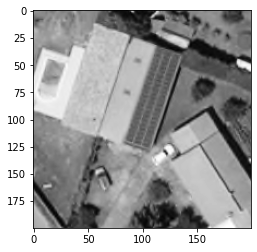

In [4]:
# Do some visualization of the features

J=3
L=8

index=50
input_shape=200

scattering=Scattering2D(J=J, shape=(input_shape,input_shape), max_order=2)


img_dir="../../data/bdappv/ign/img"
img_names=os.listdir(img_dir)
src_img=Image.open(os.path.join(img_dir,img_names[index])).convert('L')

RESIZE_AND_CROP=torchvision.transforms.Compose([
    #torchvision.transforms.Resize(128),
    torchvision.transforms.CenterCrop(input_shape),
])

src_img=RESIZE_AND_CROP(src_img)

TRANSFORMS=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
image=TRANSFORMS(src_img)
scattering_coefficients=scattering(image).squeeze(0)

print(scattering_coefficients.shape)
plt.imshow(src_img, cmap="gray")
plt.show()

In [12]:
# order one coefficients
len_order_1 = J*L
print(len_order_1)
scat_coeffs_order_1 = scattering_coefficients[1:1+len_order_1, :, :]
norm_order_1 = mpl.colors.Normalize(scat_coeffs_order_1.min(), scat_coeffs_order_1.max(), clip=True)
mapper_order_1 = cm.ScalarMappable(norm=norm_order_1, cmap="gray")
# Mapper of coefficient amplitude to a grayscale color for visualisation.
window_rows, window_columns = scattering_coefficients.shape[1:]
window_rows, window_columns

24


(8, 8)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


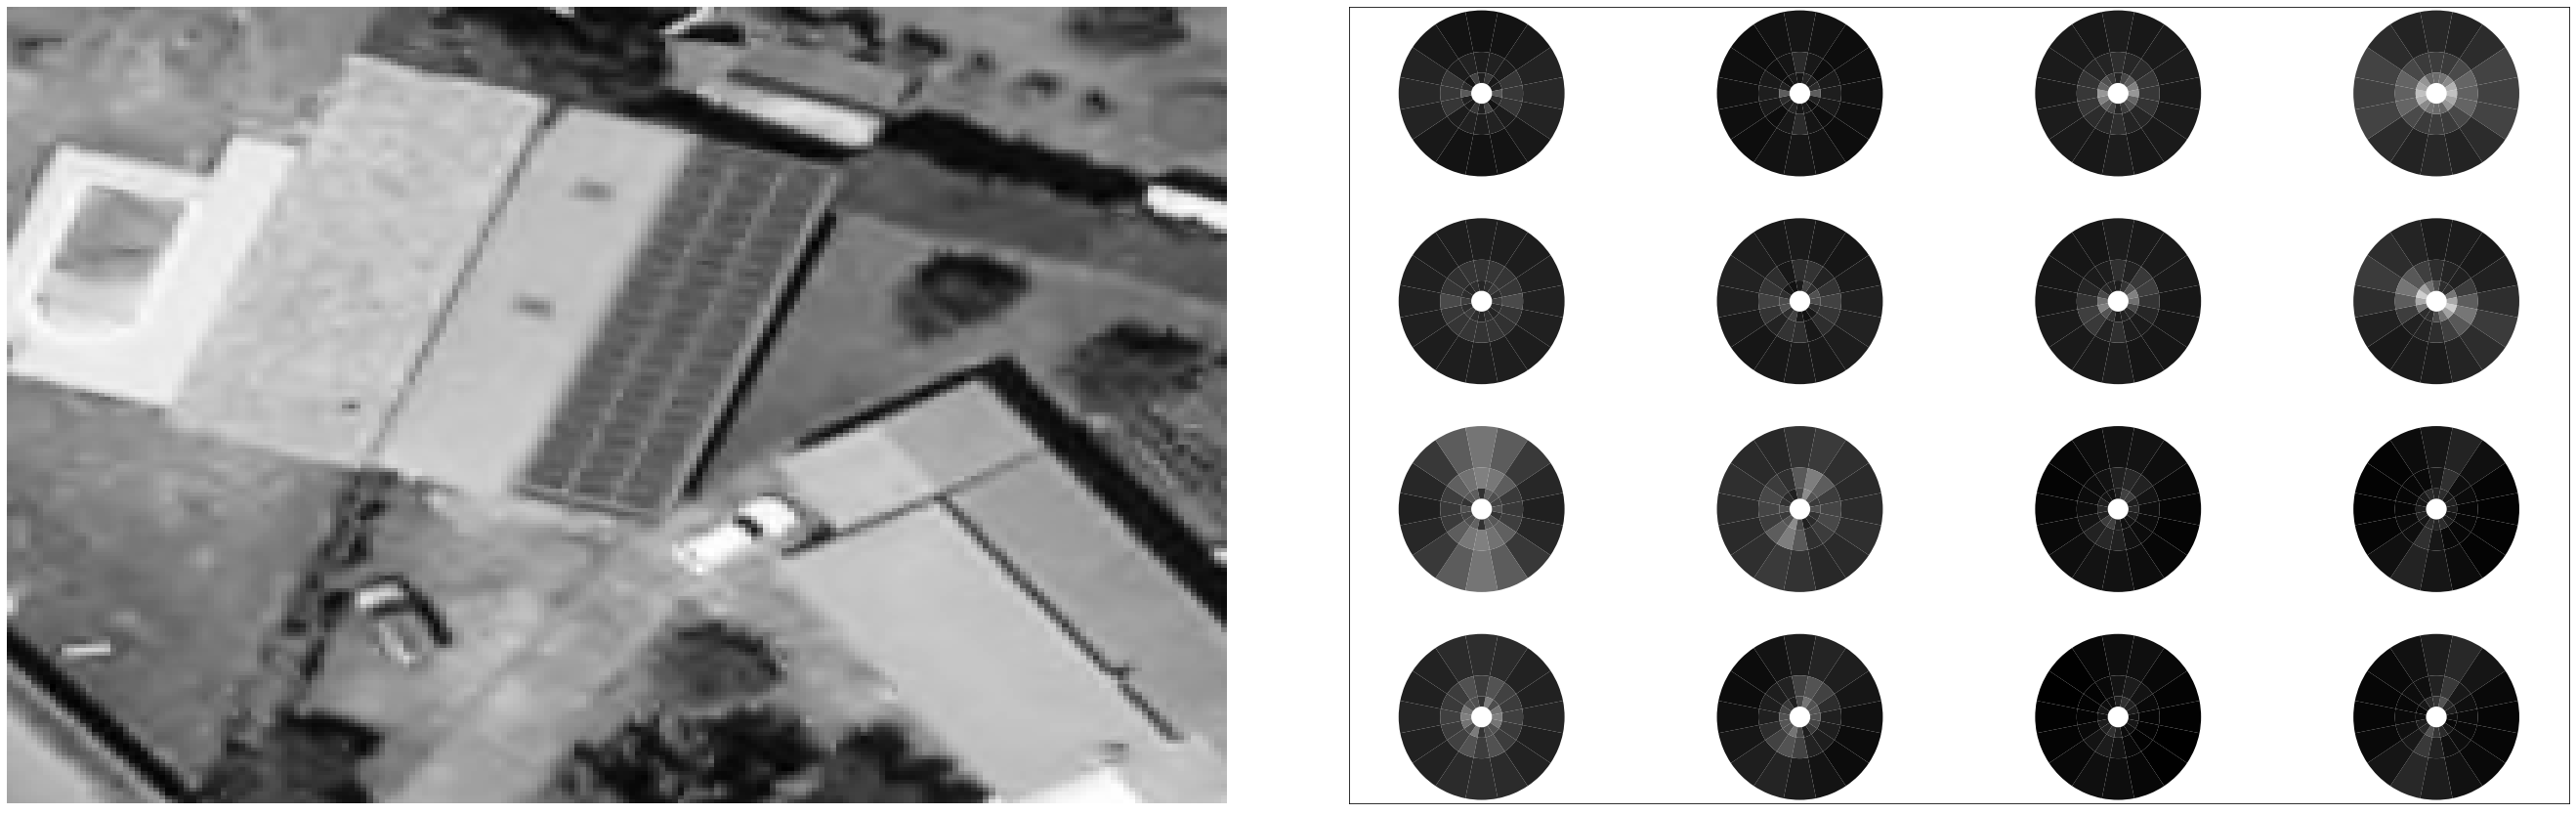

In [18]:
fig = plt.figure(figsize=(47, 15))
spec = fig.add_gridspec(ncols=2, nrows=1)

# plot only the indices in the middle

gs = gridspec.GridSpec(1, 2, wspace=0.1)
gs_order_1 = gridspec.GridSpecFromSubplotSpec(4,4, subplot_spec=gs[1])

# Start by plotting input digit image and invert colors
ax = plt.subplot(gs[0])
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(src_img,cmap='gray',interpolation='nearest', aspect='auto')
ax.axis('off')


# Plot first-order scattering coefficients
ax = plt.subplot(gs[1])
ax.set_xticks([])
ax.set_yticks([])

l_offset = int(L - L / 2 - 1)  # follow same ordering as Kymatio for angles

for row in tqdm.tqdm(range(4)):
    for column in range(4):
        ax = fig.add_subplot(gs_order_1[row, column], projection='polar')
        ax.axis('off')
        coefficients = scat_coeffs_order_1[:, row, column]
        for j in range(J):
            for l in range(L):
                coeff = coefficients[l + j * L]
                color = mapper_order_1.to_rgba(coeff)
                angle = (l_offset - l) * np.pi / L
                radius = 2 ** (-j - 1)
                ax.bar(x=angle,
                       height=radius,
                       width=np.pi / L,
                       bottom=radius,
                       color=color)
                ax.bar(x=angle + np.pi,
                       height=radius,
                       width=np.pi / L,
                       bottom=radius,
                       color=color)


plt.show()




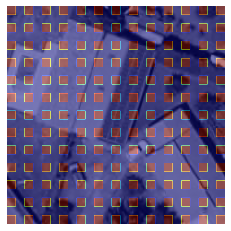

In [36]:
import cv2
import itertools

out=np.zeros((25,25))

for i,j in itertools.product(range(13),range(13)):
    out[2*j,2*i]=1



image_200x200 = cv2.resize(out, (200,200), interpolation=cv2.INTER_NEAREST)

plt.imshow(src_img, cmap="gray")
plt.imshow(image_200x200, cmap="jet", alpha=0.5)
plt.axis('off')
plt.show()

### Feature importance

We compute the importance of the features in a prediction, and then retrieve its localization on the scattering disk.

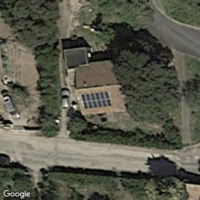

In [4]:
# load a model and define the scattering transform
input_shape=200
device="cpu"
J=1
images_dir="../../data/bdappv/google/img"
index=900
images_names=images_list['test']

# load an image

example=Image.open(os.path.join(images_dir,images_names[index])).convert('RGB')

RESIZE_AND_CROP=torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_shape)
])

TRANSFORMS=torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

tensor_img=TRANSFORMS(example)
final_img=RESIZE_AND_CROP(example)
final_img

In [5]:
device="cpu"

scattering=Scattering2D(J=J, shape=(input_shape,input_shape)).to(device)
model=torch.load(os.path.join("scattering/model_{}".format(J),"model_4.pth")) # the last model is the best
model.eval()
model.to(device)
output=model(scattering(tensor_img))
pred = output.max(1, keepdim=True)[1].squeeze(1).detach().cpu().numpy() # get the index of the max log-probability
print(pred)

[1]


In [6]:
def flatten(tensor_img, scattering, L=8,J=1):
    """
    returns a vector from the scattering coefficients
    of the image passed as input
    """
    bn=nn.BatchNorm2d(get_K(L,J))
    scattering_coeffs=scattering(tensor_img)
    out_shape=scattering_coeffs.shape[-1]
    scattering_coeffs=scattering_coeffs.view(-1, get_K(L,J), out_shape, out_shape)
    # convert as a vector
    x=bn(scattering_coeffs.view(-1, get_K(L,J), out_shape, out_shape))
    x=x.view(x.size(0), -1)
    return x


In [7]:
input_shape=200
scattering=Scattering2D(J=J, shape=(input_shape,input_shape)).to(device)
scattering_coeffs=scattering(tensor_img)
print(scattering_coeffs.shape)
vector=flatten(tensor_img, scattering)

torch.Size([3, 9, 100, 100])


In [8]:
def index_to_location(index, original_shape, intermediate_shape, new_shape):
    """
    Converts index in flattened tensor to its corresponding location in the final tensor shape.
    """
    # Calculate the sizes of each dimension
    dim1_size, dim2_size, dim3_size = original_shape
    
    # Calculate the location in the intermediate 3D tensor
    dim1_index = index // (dim2_size * dim3_size)
    remaining = index % (dim2_size * dim3_size)
    dim2_index = remaining // dim3_size
    dim3_index = remaining % dim3_size
    
    # Calculate the sizes of each dimension in the intermediate shape
    intermediate_dim1_size, intermediate_dim2_size, intermediate_dim3_size = intermediate_shape
    
    # Calculate the location in the new 4D tensor
    intermediate_index = dim1_index * intermediate_dim2_size * intermediate_dim3_size + dim2_index * intermediate_dim3_size + dim3_index
    
    intermediate_dim1_index = intermediate_index // (intermediate_dim2_size * intermediate_dim3_size)
    remaining_intermediate = intermediate_index % (intermediate_dim2_size * intermediate_dim3_size)
    intermediate_dim2_index = remaining_intermediate // intermediate_dim3_size
    intermediate_dim3_index = remaining_intermediate % intermediate_dim3_size
    
    # Calculate the sizes of each dimension in the new shape
    new_dim1_size, new_dim2_size, new_dim3_size, _ = new_shape
    
    # Calculate the location in the final 4D tensor
    new_dim1_index = intermediate_dim1_index // (intermediate_dim1_size // new_dim1_size)
    remaining_dim1 = intermediate_dim1_index % (intermediate_dim1_size // new_dim1_size)
    new_dim2_index = intermediate_dim2_index // (intermediate_dim2_size // new_dim2_size)
    remaining_dim2 = intermediate_dim2_index % (intermediate_dim2_size // new_dim2_size)
    new_dim3_index = intermediate_dim3_index
    
    return new_dim1_index, new_dim2_index, new_dim3_index, remaining_dim1 * (intermediate_dim2_size // new_dim2_size) + remaining_dim2

# Example usage
index = 115237  # Example index in the flattened tensor
original_shape = (27, 100, 100)  # Original shape of the tensor
intermediate_shape = (27, 100, 100)  # Intermediate shape
new_shape = (3, 9, 100, 100)  # New shape of the tensor

#location = index_to_location(index, original_shape, intermediate_shape, new_shape)
#print("Location in new 4D tensor:", location)


(1, 270000)


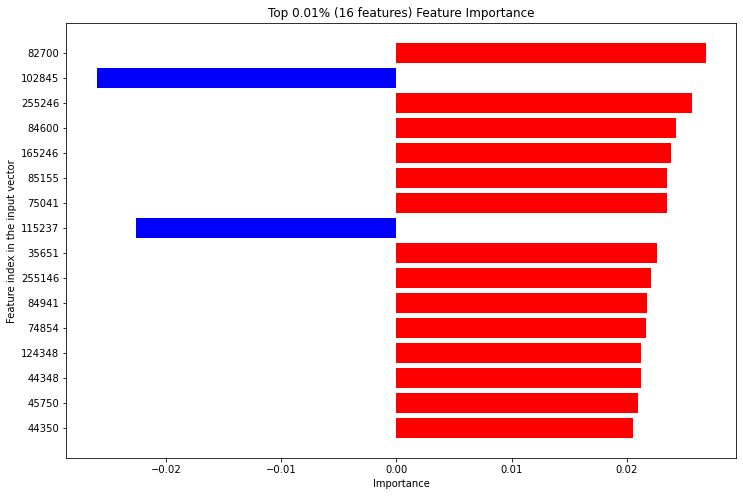

In [20]:
import shap
import numpy as np

n_features=16

explainer = shap.DeepExplainer(model.classifier, torch.tensor(np.zeros_like(vector.detach()), dtype=torch.float32))

# Compute SHAP values for the given input vector
shap_values = explainer.shap_values(vector.detach())

# Assuming shap_values has shape (1, in_features, 2)
# Extract SHAP values for class 1
shap_values_class1 = shap_values[:, :, 1]
print(shap_values_class1.shape)

# Calculate the absolute SHAP values
absolute_shap_values = np.abs(shap_values_class1)

# Get the top 100 features with highest absolute SHAP values
top_100_indices = np.argsort(absolute_shap_values.flatten())[-n_features:]
top_100_features = top_100_indices % shap_values_class1.shape[1]  # Corrected line

# Get the importance of the top 100 features
importance = shap_values_class1[0, top_100_features]

# Plot the bar plot
plt.figure(figsize=(12, 8))
colors = ['red' if imp >= 0 else 'blue' for imp in importance]
plt.barh(range(len(top_100_features)), importance, color=colors)
plt.yticks(range(len(top_100_features)), top_100_features)
plt.xlabel('Importance')
plt.ylabel('Feature index in the input vector')
plt.title('Top {:0.2f}% ({} features) Feature Importance'.format(n_features/len(absolute_shap_values.flatten())*100, n_features))
# plt.savefig('shap_values.pdf')
plt.show()


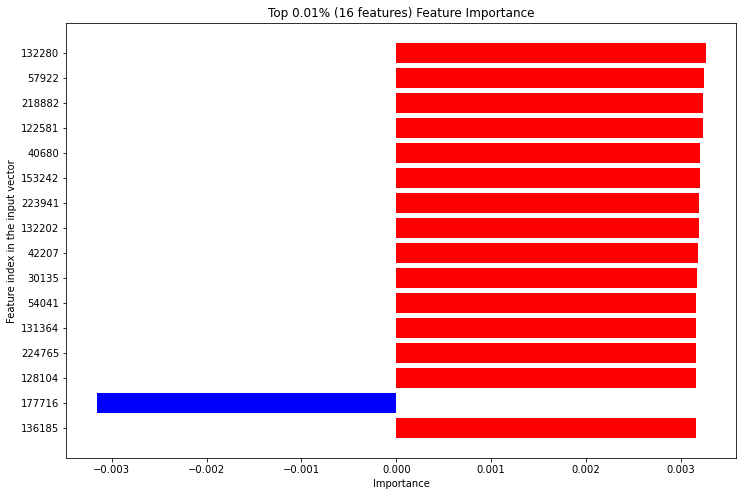

In [28]:
# alternatively, consider the model wieghts directly

# extract the weights of the model

weights=model.classifier.weight[0].detach().cpu().numpy()
# get the value of the weights

# do the same plot as above
weights=weights.reshape(1,-1)

# Calculate the absolute SHAP values
absolute_weights = np.abs(weights)

# Get the top 100 features with highest absolute SHAP values
top_100_indices = np.argsort(absolute_weights.flatten())[-n_features:]
top_100_features = top_100_indices % weights.shape[1]  # Corrected line

# Get the importance of the top 100 features
importance = weights[0, top_100_features]

# Plot the bar plot
plt.figure(figsize=(12, 8))
colors = ['red' if imp >= 0 else 'blue' for imp in importance]
plt.barh(range(len(top_100_features)), importance, color=colors)
plt.yticks(range(len(top_100_features)), top_100_features)
plt.xlabel('Importance')
plt.ylabel('Feature index in the input vector')
plt.title('Top {:0.2f}% ({} features) Feature Importance'.format(n_features/len(absolute_weights.flatten())*100, n_features))
plt.savefig('weights_values.pdf')
plt.show()

In [24]:
original_shape = (27, 100, 100)  # Original shape of the tensor
intermediate_shape = (27, 100, 100)  # Intermediate shape
new_shape = (3, 9, 100, 100)  # New shape of the tensor

locations = [
    index_to_location(index,original_shape,intermediate_shape,new_shape) for index in top_100_indices
]

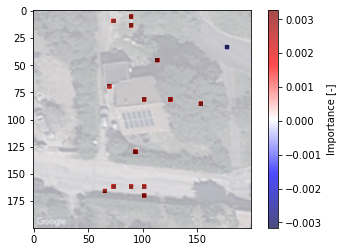

In [25]:
import cv2
map=np.zeros((50,50))

for i in range(16):

    location=locations[i]
    x,y=location[2:]

    value=importance[i]

    map[x//2,y//2]=value

upsampled=cv2.resize(map,(200,200),interpolation=cv2.INTER_NEAREST)


plt.imshow(final_img)
plt.imshow(upsampled, cmap = "seismic", alpha = 0.7)
plt.colorbar(label="Importance [-]")

plt.savefig('localisation_coefficients_weights.pdf', bbox_inches="tight")
plt.show()

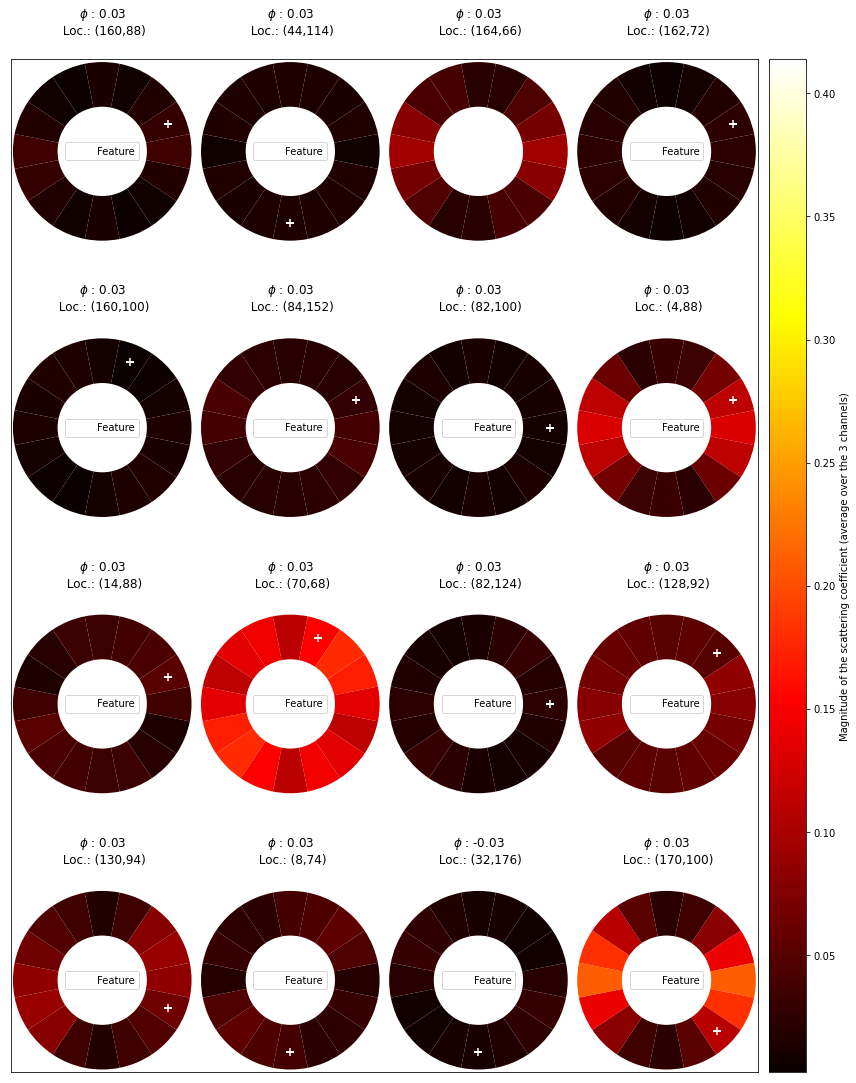

In [27]:
fig=plt.figure(figsize=(12,15))

n_features=16
anchors=4
J=1
L=8

scat_order_1=np.mean(scattering_coeffs[:,1:,:,:].numpy(),axis=0) # we only have order one coeffs
#scat_order_1=scattering_coeffs[:,1:,:,:].numpy() # we only have order one coeffs


norm_order_1 = mpl.colors.Normalize(scat_order_1.min(), scat_order_1.max(), clip=True)
mapper_order_1 = cm.ScalarMappable(norm=norm_order_1, cmap="hot") 

gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1])  # Adjust width_ratios as per your preference

# Plot first-order scattering coefficients
ax = plt.subplot(gs[0])
ax.set_xticks([])
ax.set_yticks([])

gs_order_1 = gridspec.GridSpecFromSubplotSpec(anchors, anchors, subplot_spec=gs[0], hspace=.5)


row=-1
l_offset = int(L - L / 2 - 1)  # follow same ordering as Kymatio for angles

for i in range(n_features):

    if i%anchors==0:
        row+=1
    
    ax = fig.add_subplot(gs_order_1[row, i%4], projection='polar')
    ax.axis('off')

    feature_info=locations[::-1][i]
    _,ell,x,y=feature_info
    coefficients=scattering_coeffs[:,1:,x,y].numpy()

    for j in range(J):
        for l in range(L):
            # average over the color channels (obviously information loss)
            coeff = np.mean(coefficients[:,l + j * L], axis=0) 
            #coeff = coefficients[:,l + j * L] 

            color = mapper_order_1.to_rgba(coeff)
            angle = (l_offset - l) * np.pi / L
            radius = 2 ** (-j - 1)

            title='$\phi$ : {:0.2f}\n Loc.: ({},{})'.format(10*importance[::-1][i], x*2,y*2)
            ax.set_title(title)

            ax.bar(x=angle,
                    height=radius,
                    width=np.pi / L,
                    bottom=radius,
                    color=color)
            ax.bar(x=angle + np.pi,
                    height=radius,
                    width=np.pi / L,
                    bottom=radius,
                    color=color)

            if l==ell:
                ax.scatter(angle,
                           radius + .3,
                           c='white',
                           s=50,
                           marker='+',
                           label="Feature")
                ax.legend()

cax = plt.subplot(gs[1])
cbar = plt.colorbar(mapper_order_1, cax=cax)
cbar.set_label('Magnitude of the scattering coefficient (average over the 3 channels)')

fig.tight_layout()
plt.savefig('scattering_coefficients_display_weights.pdf', bbox_inches="tight")
plt.show()

### Image similarity

Compute the RMSE between wavelet transforms at different levels of the same image to see the similarity between them. 

In [5]:
import pywt

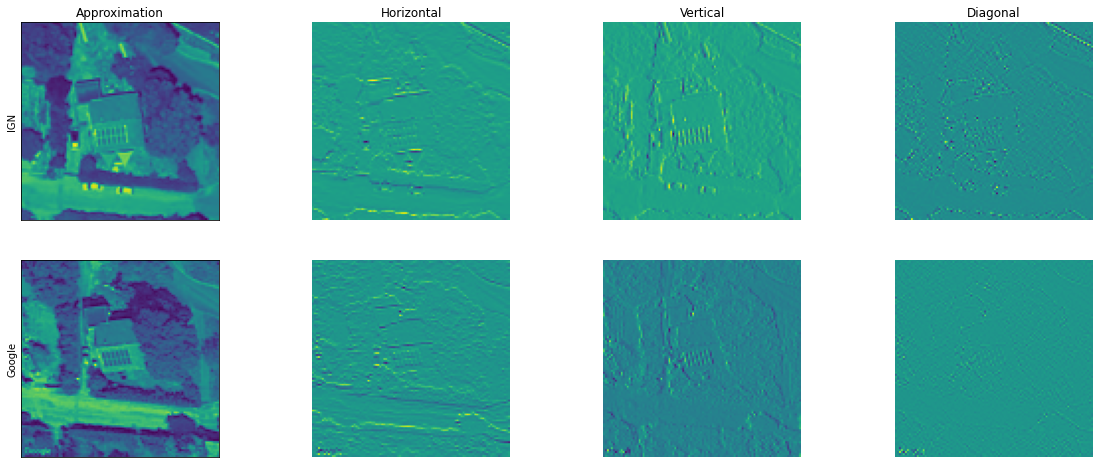

In [17]:
images_dir="../../data/bdappv/{}/img"
index=900
images_names=images_list['test']

img_google=Image.open(os.path.join(images_dir.format('google'),images_names[index])).convert('L')
# resize the google image
img_google=torchvision.transforms.Resize(200)(img_google)

img_ign=Image.open(os.path.join(images_dir.format('ign'),images_names[index])).convert('L')
# center crop the ign image
img_ign=torchvision.transforms.CenterCrop(200)(img_ign)


# compute the wavelet transforms

# finest scales

i_A, (i_LH, i_HL, i_HH) = pywt.dwt2(np.array(img_ign), "haar")
g_A, (g_LH, g_HL, g_HH) = pywt.dwt2(np.array(img_google), "haar")

fig, ax = plt.subplots(2,4, figsize=(20,8))

ax[0,0].set_title('Approximation')
ax[0,0].imshow(i_A)
ax[0,0].set_yticks([])
ax[0,0].set_xticks([])
ax[0,0].set_ylabel('IGN')

ax[1,0].imshow(g_A)
ax[1,0].set_yticks([])
ax[1,0].set_xticks([])
ax[1,0].set_ylabel('Google')


ax[0,1].set_title('Horizontal')
ax[0,1].imshow(i_LH) #horizontal
ax[0,1].axis('off')
ax[1,1].imshow(g_LH)
ax[1,1].axis('off')

ax[0,2].set_title('Vertical')
ax[0,2].imshow(i_HL) # vertical
ax[0,2].axis('off')
ax[1,2].imshow(g_HL) # vertical
ax[1,2].axis('off')

ax[0,3].set_title('Diagonal')
ax[0,3].imshow(i_HH) # diagonal
ax[0,3].axis('off')
ax[1,3].imshow(g_HH) # vertical
ax[1,3].axis('off')


plt.savefig('example_decomposition.pdf')
plt.show()

In [30]:
def rmse(image1, image2):
    # Ensure both images have the same shape
    assert image1.shape == image2.shape, "Images must have the same shape"

    # Calculate squared difference between corresponding pixel values
    squared_diff = (image1 - image2) ** 2

    # Compute the mean of squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Take the square root to obtain the RMSE
    rmse_value = np.sqrt(mean_squared_diff)

    return rmse_value




for a,b in zip([i_A,i_LH, i_HL, i_HH],[g_A,g_LH, g_HL, g_HH]):
    print(rmse(a,b))



print('--')
# compute the second level coefficients
i_A2, (i_LH2, i_HL2, i_HH2) = pywt.dwt2(i_A, "haar")
g_A2, (g_LH2, g_HL2, g_HH2) = pywt.dwt2(g_A, "haar")

# second level
for a,b in zip([i_A2,i_LH2, i_HL2, i_HH2],[g_A2,g_LH2, g_HL2, g_HH2]):
    print(rmse(a,b))

print('--')
# compute the thrid level coefficients
i_A3, (i_LH3, i_HL3, i_HH3) = pywt.dwt2(i_A2, "haar")
g_A3, (g_LH3, g_HL3, g_HH3) = pywt.dwt2(g_A2, "haar")

# second level
for a,b in zip([i_A3,i_LH3, i_HL3, i_HH3],[g_A3,g_LH3, g_HL3, g_HH3]):
    print(rmse(a,b))


120.86030313961653
21.176944420760993
16.42802407473279
6.280483659719211
--
229.5291183597411
56.868254545044735
44.41252160145831
23.211309204782058
--
424.63383894244714
135.51232628436432
93.10622522151785
58.20831362443


In [36]:
values=np.array([
    [21.176944420760993,16.42802407473279,6.280483659719211],
    [56.868254545044735,44.41252160145831,23.211309204782058],
    [135.51232628436432,93.10622522151785,58.20831362443]
])

approx=np.array([
    120.86030313961653,
    229.5291183597411,
    424.63383894244714
])

values.shape
values= np.mean(values, axis=1)
values

array([14.62848405, 41.49736178, 95.60895504])

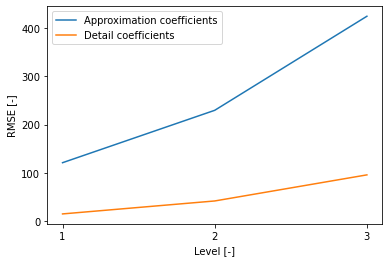

In [45]:
plt.plot(approx, label="Approximation coefficients")
plt.plot(values, label="Detail coefficients")
plt.xlabel('Level [-]')
plt.ylabel('RMSE [-]')
plt.xticks([0,1,2], [1,2,3])

plt.legend()
plt.savefig('rmse.pdf')
plt.show()

### WCAM

In [46]:
from spectral_sobol.torch_explainer import WaveletSobol
from src import utils

def rgb_to_wavelet_array(image, wavelet='haar', level=3):
    # Convert PIL image to NumPy array
    img_array = np.array(image.convert('L'))

    # Compute wavelet transform for each channel
    c = pywt.wavedec2(img_array, wavelet, level=level)     
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    arr, _ = pywt.coeffs_to_array(c)

    
    return arr


def plot_wcam(ax, image, wcam, levels, vmin = None, vmax = None):
    """
    plts the wcam
    """

    def logplot(x):
        return np.log(1 + x)
    
    size = image.size[0]
    # compute the wavelet transform
    wt = rgb_to_wavelet_array(image,level = levels)
    
    # plots
    ax.imshow(wt, cmap = 'gray')

    vmin = logplot(vmin) if vmin is not None else vmin
    vmax = logplot(vmax) if vmax is not None else vmax

    #im = ax.imshow(1 + logplot(wcam), cmap = "hot", alpha = 0.5, vmin = vmin, vmax = vmax)

    minlog = np.min(logplot(wcam))
    im = ax.imshow(minlog  + logplot(wcam), cmap = "hot", alpha = 0.7, vmin = vmin, vmax = vmax)

    ax.axis('off')
    utils.add_lines(size, levels, ax)

    #cbar = plt.colorbar(im, ax = ax)
    #cbar.ax.tick_params(labelsize=10)

    return None


2024-03-14 17:22:48.821464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 17:22:52.263558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [61]:
images_dir="../../data/bdappv/{}/img"
index=900
images_names=images_list['test']

img_google=Image.open(os.path.join(images_dir.format('google'),images_names[index])).convert('RGB')
# resize the google image
img_google=torchvision.transforms.Resize(200)(img_google)

img_ign=Image.open(os.path.join(images_dir.format('ign'),images_names[index])).convert('RGB')
# center crop the ign image
img_ign=torchvision.transforms.CenterCrop(200)(img_ign)

device='cuda'
model=torch.load("models-google/model_standard.pth").to(device)

wavelet = WaveletSobol(model.eval(), grid_size = 40, nb_design= 4, batch_size = 128, opt = {"approximation" : False})

baseline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])


x=torch.stack(
    [baseline(im) for im in [img_google,img_ign]]
).to(device)
y=np.ones(2,dtype=int)

explanation=wavelet(x,y)

/data/GabrielKasmi/deeppvmapper/wcam-application/spectral_sobol/estimators.py:143: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((a - c[i])**2.0) / (2 * nb_design * var)
/data/GabrielKasmi/miniconda3/envs/acquisition/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/GabrielKasmi/miniconda3/envs/acquisition/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


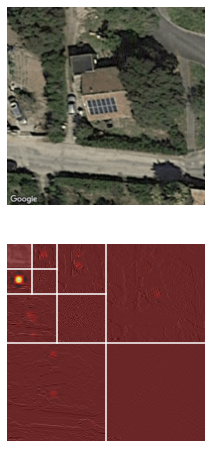

In [64]:
fig, ax=plt.subplots(2,1, figsize=(4,8))

ax[0].imshow(img_google)
ax[0].axis('off')
plot_wcam(ax[1],img_google,explanation[0],levels=3)

plt.savefig('wcam-example.pdf')
plt.show()

